# Part 2: Transformer Scaling Study

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import math
import time
from pathlib import Path
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = Path('/content/drive/MyDrive/MLProject/data')
output_dir = Path('/content/drive/MyDrive/MLProject/results')
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## Load Data

In [5]:
train_data = np.load(data_dir / 'train.npy')
val_data = np.load(data_dir / 'val.npy')

with open(data_dir / 'tokenizer.json', 'r') as f:
    token2idx = json.load(f)

vocab_size = len(token2idx)
print(f"Vocab size: {vocab_size}")
print(f"Train tokens: {len(train_data):,}")
print(f"Val tokens: {len(val_data):,}")

Vocab size: 27224
Train tokens: 1,167,894,118
Val tokens: 11,907,471


## Generate Fixed Indices

In [6]:
CONTEXT_LENGTH = 256
NUM_SAMPLES = 100_000_000 // CONTEXT_LENGTH

np.random.seed(42)

train_max_idx = len(train_data) - CONTEXT_LENGTH - 1
val_max_idx = len(val_data) - CONTEXT_LENGTH - 1

train_indices = np.random.choice(train_max_idx, size=NUM_SAMPLES, replace=False)
val_indices = np.random.choice(val_max_idx, size=NUM_SAMPLES // 10, replace=False)

np.save(data_dir / 'train_indices.npy', train_indices)
np.save(data_dir / 'val_indices.npy', val_indices)

print(f"Train indices: {len(train_indices):,}")
print(f"Val indices: {len(val_indices):,}")
print("Saved to drive")

Train indices: 390,625
Val indices: 39,062
Saved to drive


## Dataset

In [7]:
class MusicDataset(Dataset):
    def __init__(self, data, context_length, indices):
        self.data = torch.from_numpy(data.astype(np.int64))
        self.context_length = context_length
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start = self.indices[idx]
        x = self.data[start:start + self.context_length]
        y = self.data[start + 1:start + self.context_length + 1]
        return x, y

## Transformer Model

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.out_proj(out)

In [9]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.gelu(self.fc1(x))))

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.attn(self.ln1(x), mask))
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x

In [11]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, context_length, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(context_length, d_model)
        self.dropout = nn.Dropout(dropout)

        d_ff = 4 * d_model
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        self.register_buffer('mask', torch.tril(torch.ones(context_length, context_length)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        batch_size, seq_len = x.shape

        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        x = self.dropout(self.token_emb(x) + self.pos_emb(positions))

        mask = self.mask[:, :, :seq_len, :seq_len]

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)
        return logits

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Training Configuration

In [12]:
CONTEXT_LENGTH = 256
BATCH_TOKENS = 4096
BATCH_SIZE = BATCH_TOKENS // CONTEXT_LENGTH
LEARNING_RATE = 3e-4
WARMUP_RATIO = 0.05

MODEL_CONFIGS = {
    'tiny': {'n_layers': 4, 'd_model': 64, 'n_heads': 4},
    'small': {'n_layers': 6, 'd_model': 128, 'n_heads': 4},
    'medium': {'n_layers': 8, 'd_model': 256, 'n_heads': 8},
    'large': {'n_layers': 8, 'd_model': 512, 'n_heads': 8},
    'xl': {'n_layers': 8, 'd_model': 1024, 'n_heads': 16}
}

print(f"Context length: {CONTEXT_LENGTH}")
print(f"Batch size: {BATCH_SIZE} sequences ({BATCH_TOKENS} tokens)")
print(f"Samples per epoch: {len(train_indices):,}")
print(f"Steps per epoch: {len(train_indices) // BATCH_SIZE:,}")

Context length: 256
Batch size: 16 sequences (4096 tokens)
Samples per epoch: 390,625
Steps per epoch: 24,414


## Training Function

In [13]:
def get_lr(step, total_steps, warmup_steps, max_lr):
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return max_lr * 0.5 * (1 + math.cos(math.pi * progress))

In [14]:
def train_model(model_name, config, train_data, val_data, train_indices, val_indices, vocab_size):
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()} model")
    print(f"{'='*60}")

    model = Transformer(
        vocab_size=vocab_size,
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        context_length=CONTEXT_LENGTH
    ).to(device)

    n_params = model.count_parameters()
    print(f"Parameters: {n_params:,}")
    print(f"Layers: {config['n_layers']}, d_model: {config['d_model']}, heads: {config['n_heads']}")

    train_dataset = MusicDataset(train_data, CONTEXT_LENGTH, train_indices)
    val_dataset = MusicDataset(val_data, CONTEXT_LENGTH, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

    total_steps = len(train_loader)
    warmup_steps = int(total_steps * WARMUP_RATIO)

    print(f"Total steps: {total_steps:,}")
    print(f"Warmup steps: {warmup_steps:,}")

    train_losses = []

    gpu_memory = 0
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    model.train()
    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        lr = get_lr(step, total_steps, warmup_steps, LEARNING_RATE)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(loss.item())

        if step % 500 == 0:
            elapsed = time.time() - start_time
            remaining = (elapsed / (step + 1)) * (total_steps - step - 1)
            print(f"Step {step}/{total_steps} | Loss: {loss.item():.4f} | LR: {lr:.6f} | Time: {elapsed/60:.1f}m | ETA: {remaining/60:.1f}m")

    train_time = time.time() - start_time

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.max_memory_allocated() / 1e9

    model.eval()
    val_loss_total = 0
    val_steps = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
            val_loss_total += loss.item()
            val_steps += 1

    final_val_loss = val_loss_total / val_steps
    final_train_loss = sum(train_losses[-100:]) / min(100, len(train_losses))

    print(f"\nFinal train loss: {final_train_loss:.4f}")
    print(f"Final val loss: {final_val_loss:.4f}")
    print(f"Training time: {train_time/60:.1f} minutes")
    print(f"GPU memory: {gpu_memory:.2f} GB")

    results = {
        'model_name': model_name,
        'n_params': n_params,
        'config': config,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'train_losses': train_losses,
        'train_time_seconds': train_time,
        'gpu_memory_gb': gpu_memory
    }

    torch.save(model.state_dict(), output_dir / f'{model_name}_model.pt')

    del model
    torch.cuda.empty_cache()

    return results

## Train Tiny

In [15]:
results_tiny = train_model('tiny', MODEL_CONFIGS['tiny'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'results_tiny.json', 'w') as f:
    json.dump(results_tiny, f, indent=2)
print("Tiny model saved")


Training TINY model
Parameters: 3,701,120
Layers: 4, d_model: 64, heads: 4
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.3782 | LR: 0.000000 | Time: 0.0m | ETA: 492.8m
Step 500/24415 | Loss: 5.0215 | LR: 0.000123 | Time: 0.1m | ETA: 6.4m
Step 1000/24415 | Loss: 1.4462 | LR: 0.000246 | Time: 0.2m | ETA: 5.8m
Step 1500/24415 | Loss: 1.5091 | LR: 0.000300 | Time: 0.4m | ETA: 5.6m
Step 2000/24415 | Loss: 1.2205 | LR: 0.000299 | Time: 0.5m | ETA: 5.4m
Step 2500/24415 | Loss: 1.3092 | LR: 0.000298 | Time: 0.6m | ETA: 5.2m
Step 3000/24415 | Loss: 1.2504 | LR: 0.000296 | Time: 0.7m | ETA: 5.1m
Step 3500/24415 | Loss: 0.6194 | LR: 0.000293 | Time: 0.8m | ETA: 4.9m
Step 4000/24415 | Loss: 0.7049 | LR: 0.000289 | Time: 0.9m | ETA: 4.8m
Step 4500/24415 | Loss: 1.7322 | LR: 0.000285 | Time: 1.1m | ETA: 4.7m
Step 5000/24415 | Loss: 0.9125 | LR: 0.000281 | Time: 1.2m | ETA: 4.6m
Step 5500/24415 | Loss: 1.1864 | LR: 0.000275 | Time: 1.3m | ETA: 4.4m
Step 6000/24415 | Loss: 0.6359 | 

## Train Small

In [16]:
results_small = train_model('small', MODEL_CONFIGS['small'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'results_small.json', 'w') as f:
    json.dump(results_small, f, indent=2)
print("Small model saved")


Training SMALL model
Parameters: 8,192,000
Layers: 6, d_model: 128, heads: 4
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.3111 | LR: 0.000000 | Time: 0.0m | ETA: 53.3m
Step 500/24415 | Loss: 2.2701 | LR: 0.000123 | Time: 0.2m | ETA: 8.6m
Step 1000/24415 | Loss: 1.0775 | LR: 0.000246 | Time: 0.4m | ETA: 8.4m
Step 1500/24415 | Loss: 1.9032 | LR: 0.000300 | Time: 0.5m | ETA: 8.2m
Step 2000/24415 | Loss: 1.1704 | LR: 0.000299 | Time: 0.7m | ETA: 8.0m
Step 2500/24415 | Loss: 0.9836 | LR: 0.000298 | Time: 0.9m | ETA: 7.8m
Step 3000/24415 | Loss: 1.0509 | LR: 0.000296 | Time: 1.1m | ETA: 7.6m
Step 3500/24415 | Loss: 1.3606 | LR: 0.000293 | Time: 1.2m | ETA: 7.4m
Step 4000/24415 | Loss: 0.7329 | LR: 0.000289 | Time: 1.4m | ETA: 7.2m
Step 4500/24415 | Loss: 1.5670 | LR: 0.000285 | Time: 1.6m | ETA: 7.1m
Step 5000/24415 | Loss: 1.5778 | LR: 0.000281 | Time: 1.8m | ETA: 6.9m
Step 5500/24415 | Loss: 0.8399 | LR: 0.000275 | Time: 2.0m | ETA: 6.7m
Step 6000/24415 | Loss: 1.1331 |

## Train Medium

In [17]:
results_medium = train_model('medium', MODEL_CONFIGS['medium'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'results_medium.json', 'w') as f:
    json.dump(results_medium, f, indent=2)
print("Medium model saved")


Training MEDIUM model
Parameters: 20,322,816
Layers: 8, d_model: 256, heads: 8
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.4263 | LR: 0.000000 | Time: 0.0m | ETA: 61.2m
Step 500/24415 | Loss: 1.4727 | LR: 0.000123 | Time: 0.3m | ETA: 15.7m
Step 1000/24415 | Loss: 1.4025 | LR: 0.000246 | Time: 0.7m | ETA: 15.4m
Step 1500/24415 | Loss: 1.0527 | LR: 0.000300 | Time: 1.0m | ETA: 15.0m
Step 2000/24415 | Loss: 1.0252 | LR: 0.000299 | Time: 1.3m | ETA: 14.7m
Step 2500/24415 | Loss: 1.1068 | LR: 0.000298 | Time: 1.6m | ETA: 14.4m
Step 3000/24415 | Loss: 1.1032 | LR: 0.000296 | Time: 2.0m | ETA: 14.0m
Step 3500/24415 | Loss: 0.9251 | LR: 0.000293 | Time: 2.3m | ETA: 13.7m
Step 4000/24415 | Loss: 0.7576 | LR: 0.000289 | Time: 2.6m | ETA: 13.4m
Step 4500/24415 | Loss: 0.7968 | LR: 0.000285 | Time: 2.9m | ETA: 13.0m
Step 5000/24415 | Loss: 0.9290 | LR: 0.000281 | Time: 3.3m | ETA: 12.7m
Step 5500/24415 | Loss: 0.6589 | LR: 0.000275 | Time: 3.6m | ETA: 12.4m
Step 6000/24415 | L

## Train Large

In [18]:
results_large = train_model('large', MODEL_CONFIGS['large'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'results_large.json', 'w') as f:
    json.dump(results_large, f, indent=2)
print("Large model saved")


Training LARGE model
Parameters: 53,228,544
Layers: 8, d_model: 512, heads: 8
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.2736 | LR: 0.000000 | Time: 0.0m | ETA: 79.1m
Step 500/24415 | Loss: 1.4854 | LR: 0.000123 | Time: 0.7m | ETA: 31.9m
Step 1000/24415 | Loss: 0.9310 | LR: 0.000246 | Time: 1.3m | ETA: 31.2m
Step 1500/24415 | Loss: 0.9763 | LR: 0.000300 | Time: 2.0m | ETA: 30.5m
Step 2000/24415 | Loss: 1.0616 | LR: 0.000299 | Time: 2.7m | ETA: 29.9m
Step 2500/24415 | Loss: 0.6285 | LR: 0.000298 | Time: 3.3m | ETA: 29.2m
Step 3000/24415 | Loss: 0.1844 | LR: 0.000296 | Time: 4.0m | ETA: 28.5m
Step 3500/24415 | Loss: 0.7528 | LR: 0.000293 | Time: 4.7m | ETA: 27.8m
Step 4000/24415 | Loss: 0.6880 | LR: 0.000289 | Time: 5.3m | ETA: 27.2m
Step 4500/24415 | Loss: 0.7455 | LR: 0.000285 | Time: 6.0m | ETA: 26.5m
Step 5000/24415 | Loss: 0.4051 | LR: 0.000281 | Time: 6.7m | ETA: 25.8m
Step 5500/24415 | Loss: 0.3857 | LR: 0.000275 | Time: 7.3m | ETA: 25.2m
Step 6000/24415 | Lo

## Train XL

In [19]:
results_xl = train_model('xl', MODEL_CONFIGS['xl'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'results_xl.json', 'w') as f:
    json.dump(results_xl, f, indent=2)
print("XL model saved")


Training XL model
Parameters: 156,788,736
Layers: 8, d_model: 1024, heads: 16
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.4003 | LR: 0.000000 | Time: 0.0m | ETA: 143.8m
Step 500/24415 | Loss: 1.0004 | LR: 0.000123 | Time: 1.8m | ETA: 86.7m
Step 1000/24415 | Loss: 1.0096 | LR: 0.000246 | Time: 3.6m | ETA: 84.9m
Step 1500/24415 | Loss: 0.6126 | LR: 0.000300 | Time: 5.4m | ETA: 83.0m
Step 2000/24415 | Loss: 0.8749 | LR: 0.000299 | Time: 7.3m | ETA: 81.2m
Step 2500/24415 | Loss: 0.4483 | LR: 0.000298 | Time: 9.1m | ETA: 79.4m
Step 3000/24415 | Loss: 0.6853 | LR: 0.000296 | Time: 10.9m | ETA: 77.6m
Step 3500/24415 | Loss: 0.4796 | LR: 0.000293 | Time: 12.7m | ETA: 75.8m
Step 4000/24415 | Loss: 0.8888 | LR: 0.000289 | Time: 14.5m | ETA: 74.0m
Step 4500/24415 | Loss: 0.3790 | LR: 0.000285 | Time: 16.3m | ETA: 72.2m
Step 5000/24415 | Loss: 0.7631 | LR: 0.000281 | Time: 18.1m | ETA: 70.4m
Step 5500/24415 | Loss: 0.5780 | LR: 0.000275 | Time: 19.9m | ETA: 68.5m
Step 6000/244

## Results Summary

In [5]:
all_results = []
for name in ['tiny', 'small', 'medium', 'large', 'xl']:
    with open(output_dir / f'results_{name}.json', 'r') as f:
        all_results.append(json.load(f))

print("\n" + "="*80)
print("SCALING STUDY RESULTS")
print("="*80)
print(f"{'Model':<10} {'Params':>12} {'Train Loss':>12} {'Val Loss':>12} {'Time (min)':>12} {'GPU (GB)':>10}")
print("-"*80)

for r in all_results:
    print(f"{r['model_name']:<10} {r['n_params']:>12,} {r['final_train_loss']:>12.4f} {r['final_val_loss']:>12.4f} {r['train_time_seconds']/60:>12.1f} {r['gpu_memory_gb']:>10.2f}")

print("="*80)


SCALING STUDY RESULTS
Model            Params   Train Loss     Val Loss   Time (min)   GPU (GB)
--------------------------------------------------------------------------------
tiny          3,701,120       0.9264       0.8684          5.7       2.08
small         8,192,000       0.6485       0.6150          8.7       2.36
medium       20,322,816       0.4902       0.4662         16.0       3.25
large        53,228,544       0.4205       0.4021         32.5       4.24
xl          156,788,736       0.4073       0.3751         88.5       7.50


## Scaling Plot

In [6]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

params = [r['n_params'] for r in all_results]
val_losses = [r['final_val_loss'] for r in all_results]

def power_law(N, a, alpha, c):
    return a * np.power(N, -alpha) + c

try:
    popt, pcov = curve_fit(power_law, params, val_losses, p0=[1, 0.1, 1], maxfev=10000)
    a, alpha, c = popt
    print(f"Power law fit: L = {a:.4f} * N^(-{alpha:.4f}) + {c:.4f}")
    print(f"Scaling exponent α = {alpha:.4f}")
except:
    print("Could not fit power law")
    a, alpha, c = None, None, None

Power law fit: L = 274643.6815 * N^(-0.8717) + 0.3530
Scaling exponent α = 0.8717


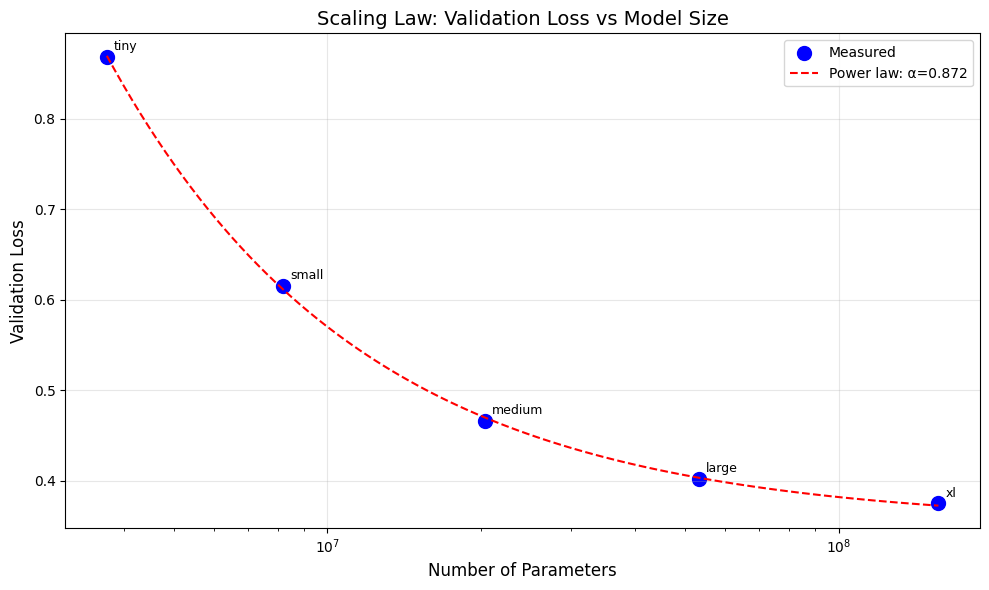

In [22]:
plt.figure(figsize=(10, 6))

plt.scatter(params, val_losses, s=100, c='blue', label='Measured')

for r in all_results:
    plt.annotate(r['model_name'], (r['n_params'], r['final_val_loss']),
                 textcoords="offset points", xytext=(5,5), fontsize=9)

if a is not None:
    x_fit = np.logspace(np.log10(min(params)), np.log10(max(params)), 100)
    y_fit = power_law(x_fit, a, alpha, c)
    plt.plot(x_fit, y_fit, 'r--', label=f'Power law: α={alpha:.3f}')

plt.xscale('log')
plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Scaling Law: Validation Loss vs Model Size', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'scaling_plot.png', dpi=150)
plt.show()

## Training Curves

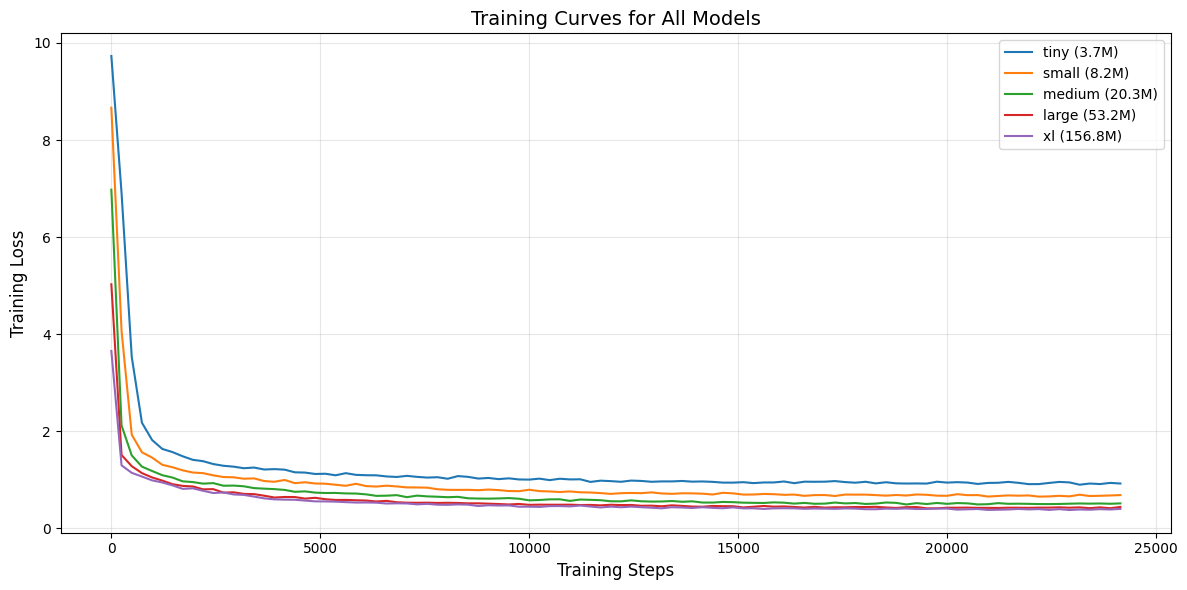

In [23]:
plt.figure(figsize=(12, 6))

for r in all_results:
    losses = r['train_losses']
    window = max(1, len(losses) // 100)
    smoothed = [sum(losses[i:i+window])/window for i in range(0, len(losses)-window, window)]
    steps = [i * window for i in range(len(smoothed))]
    plt.plot(steps, smoothed, label=f"{r['model_name']} ({r['n_params']/1e6:.1f}M)")

plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Curves for All Models', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'training_curves.png', dpi=150)
plt.show()

## Model Architecture Table

In [24]:
print("\nModel Architecture Summary:")
print("="*70)
print(f"{'Model':<10} {'Layers':>8} {'d_model':>10} {'Heads':>8} {'d_ff':>10} {'Params':>15}")
print("-"*70)

for r in all_results:
    cfg = r['config']
    d_ff = 4 * cfg['d_model']
    print(f"{r['model_name']:<10} {cfg['n_layers']:>8} {cfg['d_model']:>10} {cfg['n_heads']:>8} {d_ff:>10} {r['n_params']:>15,}")

print("="*70)


Model Architecture Summary:
Model        Layers    d_model    Heads       d_ff          Params
----------------------------------------------------------------------
tiny              4         64        4        256       3,701,120
small             6        128        4        512       8,192,000
medium            8        256        8       1024      20,322,816
large             8        512        8       2048      53,228,544
xl                8       1024       16       4096     156,788,736
